In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, concatenate  # Note 'concatenate', not 'Concatenate'.

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist

# To prevent CUBLAS_STATUS_ALLOC_FAILED problem in tensorflow 2, the follwing codes are necessary.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# mnist CNN model with 2 Inputs (Y-network)

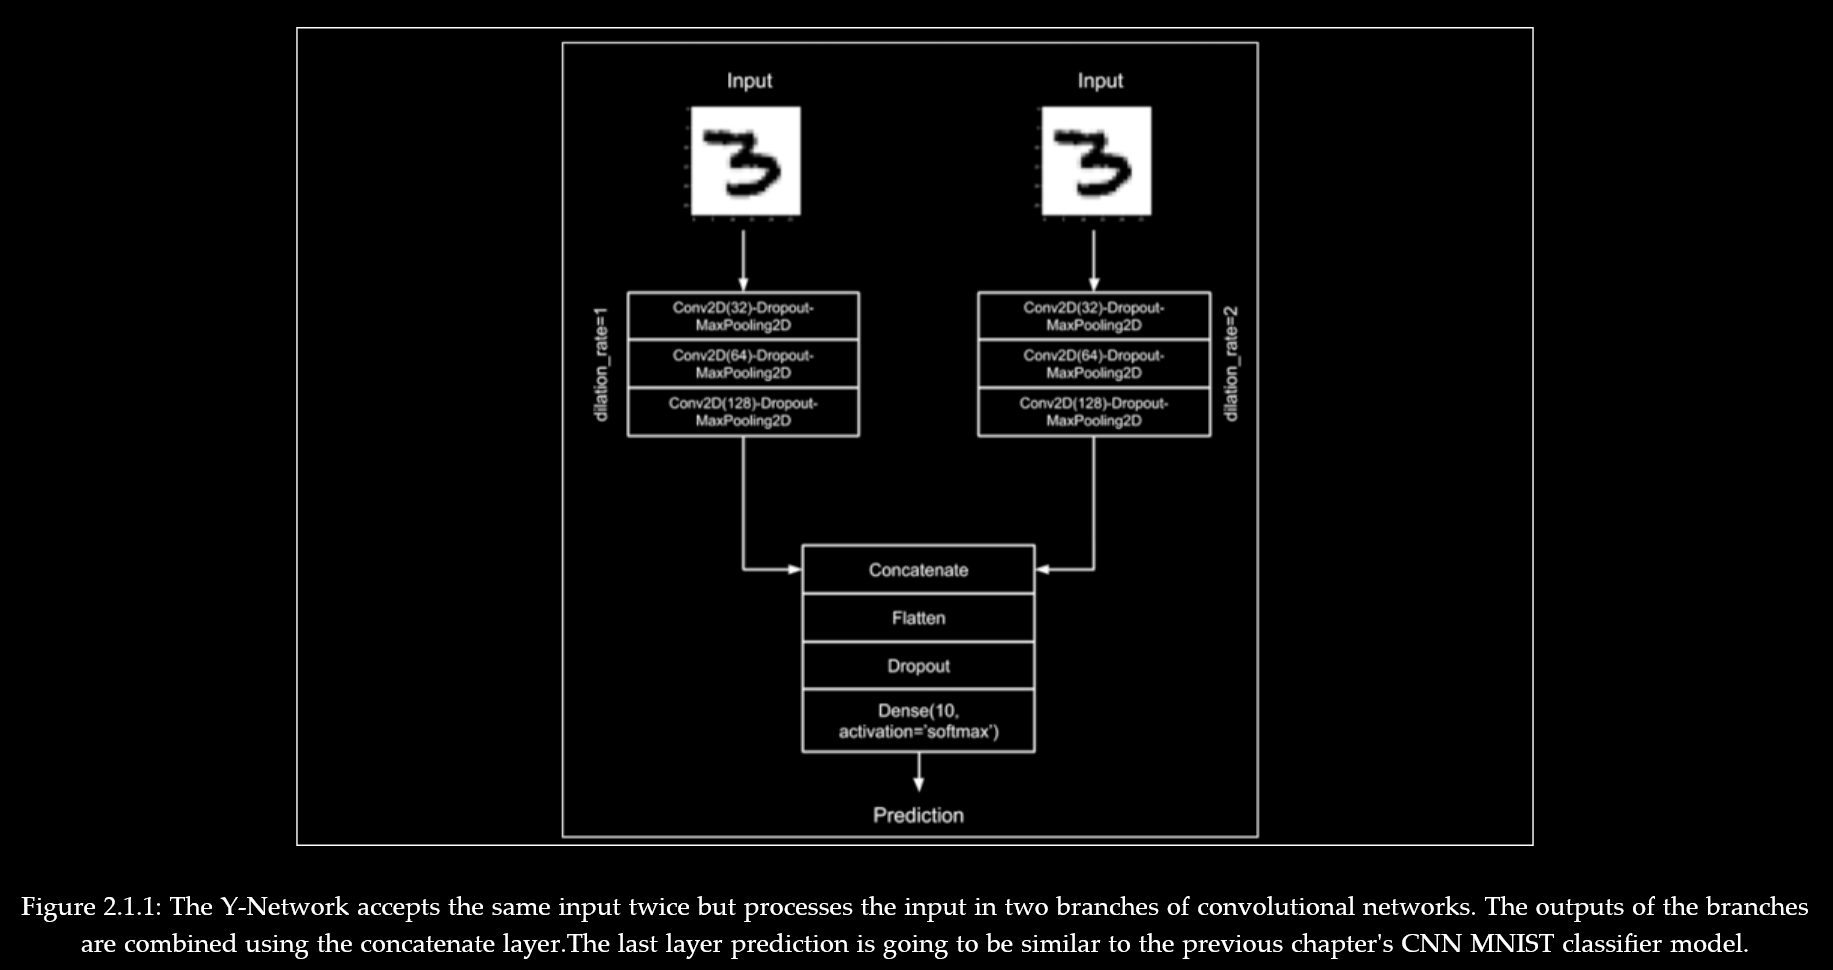

To improve the performance of the model in Listing 2.1.1 , we can propose several changes. 

Firstly, the branches of the Y-Network are __doubling the number of filters to compensate for the halving of the feature maps size after MaxPooling2D()__ . For example, if the output of the first convolution is (28, 28, 32), after max pooling the new shape is (14, 14, 32). The next convolution will have a filter size of 64 and output dimensions of (14, 14, 64).

Second, although both branches have the same kernel size of 3, __the right branch uses a dilation rate of 2.__ Figure 2.1.2 shows the effect of different dilation rates on a kernel with size 3. The idea is that by increasing the effective receptive field size of the kernel using dilation rate, the CNN will enable the right branch to learn different feature maps. Using a dilation rate greater than 1 is a computationally efficient approximate method to increase receptive field size. It is approximate since the kernel is not actually a full-blown kernel. It is efficient since we use the same number of operations as with a dilation rate equal to 1. We'll use the option padding='same' to ensure that we will not have negative tensor dimensions when the dilated CNN is used.

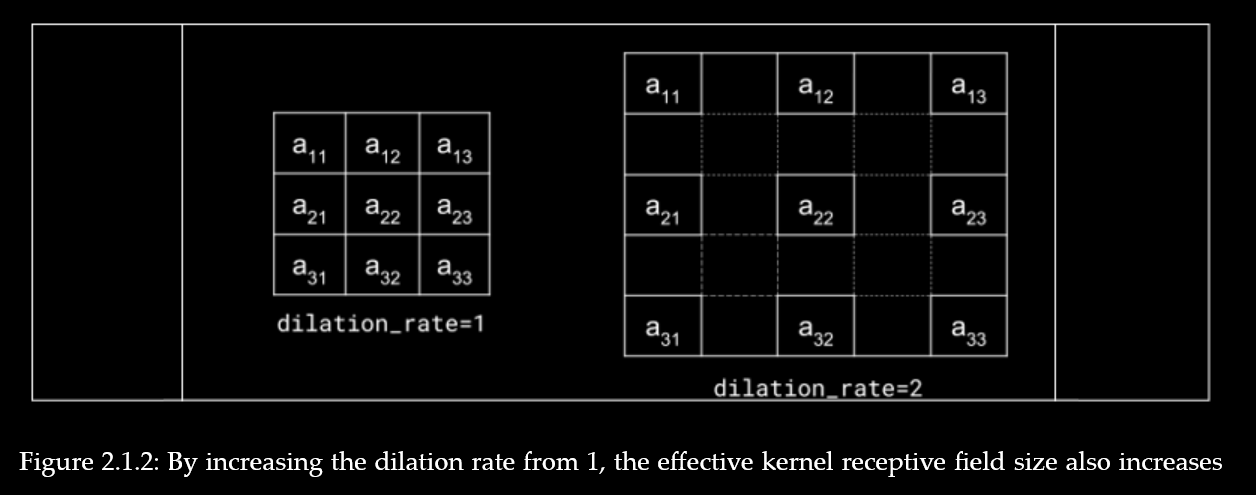

In [2]:
# Step 1: Data preparation

(x_train, y_train), (x_test, y_test) = mnist.load_data()

num_labels = len(np.unique(y_train))

# One hot encoding

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# reshaping
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

# normalizing

x_train = x_train/ 255.
x_test = x_test/ 255.

In [3]:
# Step 2: Model Construction for Y-network

# Hyperparameter setup
image_size = x_train.shape[1]
input_shape=(image_size, image_size, 1)
kernel_size=3
batch_size=128
dropout=0.4
n_filters=32
epochs=20

# left branch of Y-network
left_inputs = Input(shape=input_shape)
x=left_inputs
filters=n_filters

# 3-layers of Conv2D-Dropout-Maxpooling2D

for i in range(3):
    x=Conv2D(kernel_size=kernel_size, filters=filters, activation='relu',padding='same')(x)
    x=Dropout(dropout)(x)
    x=MaxPooling2D()(x)
    filters*=2  # number of filters doubles after each layer (32-64-128)

# right branch of Y-network

right_inputs = Input(shape=input_shape)
y = right_inputs
filters=n_filters

# 3-layers of Conv2D-Dropout-Maxpooling2D

for i in range(3):
    y = Conv2D(kernel_size=kernel_size, filters=filters, 
               activation='relu', 
               dilation_rate = 2,  # the right branch uses a dilation rate of 2.
               padding='same')(y)  # use the option padding='same' to ensure that we will not have negative tensor. 
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    filters *= 2
    
# merge left and right branches outputs

y = concatenate([x, y]) # Note 'concatenate', not 'Concatenate'.

# feature maps to vector before connecting to Dense 

y = Flatten()(y)
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

# Build the model in functional API

model = Model([left_inputs, right_inputs], outputs)

plot_model(model,show_shapes = True, to_file='cnn-Y-network.png')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
______________________________________________________________________________________________

In [4]:
# Step 3:  Model Compile

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [5]:
# Step 4: Model Fit

import time
start_time = time.time()

model.fit([x_train, x_train], y_train, 
                  validation_data =([x_test,x_test], y_test),
                  batch_size=batch_size, epochs=epochs)

print("Execution time in seconds = {:2f}".format(time.time()-start_time))

Epoch 1/20
469/469 [==============================] - 9s 14ms/step - loss: 0.5573 - accuracy: 0.8213 - val_loss: 0.2145 - val_accuracy: 0.9858
Epoch 2/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0848 - accuracy: 0.9732 - val_loss: 0.1393 - val_accuracy: 0.9902
Epoch 3/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0609 - accuracy: 0.9814 - val_loss: 0.0988 - val_accuracy: 0.9906
Epoch 4/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0481 - accuracy: 0.9848 - val_loss: 0.0879 - val_accuracy: 0.9922
Epoch 5/20
469/469 [==============================] - 5s 12ms/step - loss: 0.0417 - accuracy: 0.9871 - val_loss: 0.0725 - val_accuracy: 0.9923
Epoch 6/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0390 - accuracy: 0.9874 - val_loss: 0.0682 - val_accuracy: 0.9922
Epoch 7/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0349 - accuracy: 0.9898 - val_loss: 0.0696 - val_accuracy: 0.9931

In [6]:
# Step 5: Model Evaluation

score = model.evaluate([x_test, x_test], y_test, batch_size=batch_size)
print('Test Accuracy = {:.2%}'.format(score[1]))

# Over the course of the 20 epochs, the accuracy of the Y-Network ranges from 99.4% to 99.5%. 
# This is a slight improvement over the 3-stack CNN which achieved a range between 99.3% and 99.4% accuracy. 
# However, this was at the cost of both higher complexity and more than double the number of parameters.

79/79 [==============================] - 0s 4ms/step - loss: 0.0242 - accuracy: 0.9947
Test Accuracy = 99.47%
